Importing libraries and defining the various MIMO related functions which will be later used in the Projects

In [1]:
# MIMO file
import numpy as np
import numpy.linalg as nl
import numpy.random as nr
from scipy.stats import norm
from scipy.stats import unitary_group


def Dmatrix(K):
    var_nr = (10**(8/10))**2; mean_nr = 3;
    mu_nr = np.log10(mean_nr**2/np.sqrt(var_nr+mean_nr**2));
    sigma_nr = np.sqrt(np.log10(var_nr/(mean_nr**2+1)));
    nr = np.random.lognormal(mu_nr,sigma_nr,K);
    dr = np.random.randint(100,1000,K)/100;
    beta = nr/dr**3.0;
    return beta;

def DFTmat(K):
    kx, lx = np.meshgrid(np.arange(K), np.arange(K))
    omega = np.exp(-2*np.pi*1j/K)
    dftmtx = np.power(omega,kx*lx)
    return dftmtx

def Q(x):
    return 1-norm.cdf(x);

def QPSK(m,n):
    return ((2*nr.randint(2,size=(m,n))-1)+1j*(2*nr.randint(2,size=(m,n))-1))/np.sqrt(2);

def H(G):
    return np.conj(np.transpose(G));

def ArrayDictionary(G,t):
    lxx = 2/G*np.arange(G)-1;
    lx, kx = np.meshgrid(lxx, np.arange(t));
    omega = np.exp(-1j*np.pi);
    dmtx = 1/np.sqrt(t)*np.power(omega,kx*lx);
    return dmtx;

def RF_BB_matrices(numAnt,numRF,N_Beam):
    NBlk = numAnt/numRF;
    RFmat = 1/np.sqrt(numAnt)*DFTmat(numAnt);
    U = unitary_group.rvs(numRF);
    V = unitary_group.rvs(int(N_Beam/NBlk));
    CenterMat = np.concatenate((np.identity(int(N_Beam/NBlk)),
                                np.zeros((int(numRF-N_Beam/NBlk),int(N_Beam/NBlk)))),axis=0);
    BB_diag = nl.multi_dot([U,CenterMat,H(V)]);
    BBmat = np.kron(np.identity(int(NBlk)),BB_diag);
    return RFmat, BBmat

def OMP(y,Q,thrld):
    [rq,cq] = Q.shape;
    set_I = np.zeros(cq);
    r_prev = np.zeros((rq,1));
    hb_omp = np.zeros((cq,1)) + np.zeros((cq,1))*1j;
    r_curr = y;
    Qa = np.zeros((rq,cq))+ np.zeros((rq,cq))*1j;
    ix1 = 0;
    while np.absolute(nl.norm(r_prev)**2 - nl.norm(r_curr)**2) > thrld:
        m_ind = np.argmax(np.absolute(np.matmul(H(Q),r_curr)));
        set_I[ix1] = m_ind;
        Qa[:,ix1] = Q[:,m_ind];
        hb_ls = np.matmul(nl.pinv(Qa[:,0:ix1+1]),y);
        r_prev = r_curr;
        r_curr = y - np.matmul(Qa[:,0:ix1+1],hb_ls);
        ix1 = ix1 + 1;

    set_I_nz = set_I[0:ix1];
    hb_omp[set_I_nz.astype(int)] = hb_ls;
    return hb_omp

def SOMP(Opt, Dict, Ryy, numRF):
    rq, cq = np.shape(Dict);
    Res = Opt;
    RF = np.zeros((rq,numRF))+1j*np.zeros((rq,numRF));
    for iter1 in range(numRF):
        phi = nl.multi_dot([H(Dict),Ryy,Res]);
        phi_phiH = AAH(phi);
        m_ind = np.argmax(np.abs(np.diag(phi_phiH)));
        RF[:,iter1] = Dict[:,m_ind];
        RFc = RF[:,0:iter1+1];
        BB = nl.multi_dot([nl.inv(nl.multi_dot([H(RFc),Ryy,RFc])),H(RFc),Ryy,Opt]);
        Res = (Opt-np.matmul(RFc,BB))/nl.norm(Opt-np.matmul(RFc,BB));
    return  BB, RF


def SOMP_Est(y,Qbar,thrld):
    rq,cq = np.shape(Qbar);
    ry,cy = np.shape(y);
    set_I = np.zeros((cq,1));
    r_prev = np.zeros((ry,cy))+1j*np.zeros((ry,cy));
    hb_OMP = np.zeros((cq,cy))+1j*np.zeros((cq,cy));
    r_curr = y;
    Q_a = np.zeros((rq,cq))+1j*np.zeros((rq,cq));
    ix1 = 0;
    while(abs((nl.norm(r_prev,2))**2 - (nl.norm(r_curr,2))**2) > thrld):
        psi = nl.multi_dot([H(Qbar),r_curr]);
        m_ind = np.argmax(np.abs(np.diag(AAH(psi))));
        set_I[ix1] = m_ind;
        Q_a[:,ix1] = Qbar[:,m_ind];
        Q_c = Q_a[:,0:ix1+1];
        Hb_LS = np.matmul(nl.pinv(Q_c),y);
        r_prev = r_curr;
        r_curr = y - np.matmul(Q_c,Hb_LS);
        ix1 = ix1 + 1;
    set_I_nz = set_I[0:ix1];
    hb_OMP[set_I_nz.astype(int).flatten(),:] = Hb_LS;
    return hb_OMP

def MSE_time_domain(H,Ht,Fsub,r,t,Nt):
    Ht_est = np.zeros((r,t,Nt))+1j*np.zeros((r,t,Nt));
    for tx in range(t):
        for rx in range(r):
            Ht_est[rx,tx,:] = np.matmul(nl.pinv(Fsub),H[rx,tx,:]);
    MSE_td = nl.norm(Ht.flatten()-Ht_est.flatten())**2/t/r/Nt;
    return MSE_td

def SBL(y,Q,sigma_2):
    N, M = np.shape(Q);
    Gamma = np.identity(M);
    for iter in range(50):
        Sigma = nl.inv(1/sigma_2*np.matmul(H(Q),Q) + nl.inv(Gamma));
        mu = 1/sigma_2*nl.multi_dot([Sigma,H(Q),y]);
        Gamma = np.diag(np.diag(Sigma)+np.abs(mu).flatten()**2);
    return mu, Gamma



def mmWaveMIMOChannelGenerator(A_R,A_T,G,L):
    t = A_T.shape[0];
    r = A_R.shape[0];
    Psi = np.zeros(shape=(t*r,L))+np.zeros(shape=(t*r,L))*1j;
    tax = nr.choice(G, L, replace=False);
    rax = nr.choice(G, L, replace=False);
    alpha = 1/np.sqrt(2)*(nr.normal(0,1,L)+1j*nr.normal(0,1,L));
    A_T_genie = A_T[:, tax];
    A_R_genie = A_R[:, rax];
    for jx in range(L):
        Psi[:,jx] = np.kron(np.conj(A_T[:,tax[jx]]),A_R[:,rax[jx]]);
    return alpha, Psi, A_R_genie, A_T_genie


def mmWaveMIMO_OFDMChannelGenerator(A_R,A_T,L,numTaps):
    t,G = np.shape(A_T);
    r,G = np.shape(A_R);
    Ht = np.zeros((r,t,numTaps)) + 1j*np.zeros((r,t,numTaps));
    Psi = np.zeros(shape=(t*r,L))+np.zeros(shape=(t*r,L))*1j;
    tax = nr.choice(G, L, replace=False);
    rax = nr.choice(G, L, replace=False);
    A_T_genie = A_T[:, tax];
    A_R_genie = A_R[:, rax];
    for jx in range(L):
        Psi[:,jx] = np.kron(np.conj(A_T[:,tax[jx]]),A_R[:,rax[jx]]);
    for px in range(numTaps):
        alpha = 1/np.sqrt(2)*(nr.normal(0,1,L)+1j*nr.normal(0,1,L));
        Ht[:,:,px] = np.sqrt(t*r/L)*nl.multi_dot([A_R_genie,np.diag(alpha),H(A_T_genie)])
    return Ht, Psi, A_R_genie, A_T_genie



def AHA(A):
    return np.matmul(H(A),A)

def AAH(A):
    return np.matmul(A,H(A))

def mimo_capacity(Hmat, TXcov, Ncov):
    r, c = np.shape(Hmat);
    inLD = np.identity(r) + nl.multi_dot([nl.inv(Ncov),Hmat,TXcov,H(Hmat)]);
    C = np.log2(nl.det(inLD));
    return np.abs(C)


# This defines the Water filling algorithm used for Optimal Power allocation
def OPT_CAP_MIMO(Heff,SNR):
    U, S, V = nl.svd(Heff, full_matrices=False)
    t = len(S);
    CAP = 0;
    while not CAP:
        onebylam = (SNR + sum(1/S[0:t]**2))/t;
        if  onebylam - 1/S[t-1]**2 >= 0:
            optP = onebylam - 1/S[0:t]**2;
            CAP = sum(np.log2(1+ S[0:t]**2 * optP));
        elif onebylam - 1/S[t-1]**2 < 0:
            t = t-1;
    return CAP

def EQ_CAP_MIMO(Heff,SNR):
    U, S, V = nl.svd(Heff, full_matrices=False)
    t = len(S);
    CAP = sum(np.log2(1+ S[0:t]**2 * SNR/t));
    return CAP


def MPAM_DECODER(EqSym,M):
    DecSym = np.round((EqSym+M-1)/2);
    DecSym[np.where(DecSym<0)] = 0;
    DecSym[np.where(DecSym>(M-1))] = M-1
    return DecSym

def MQAM_DECODER(EqSym,M):
    sqM = np.int(np.sqrt(M));
    DecSym = np.round((EqSym+sqM-1)/2);
    DecSym[np.where(DecSym<0)]=0;
    DecSym[np.where(DecSym>(sqM-1))]=sqM-1
    return DecSym

def PHYDAS(L_f,N):
    H1=0.971960;
    H2=np.sqrt(2)/2;
    H3=0.235147;
    fh=1+2*(H1+H2+H3);
    hef=np.zeros((1,L_f+1));
    for i in range(L_f+1):
        hef[0,i]=1-2*H1*np.cos(np.pi*i/(2*N))+2*H2*np.cos(np.pi*i/N)-2*H3*np.cos(np.pi*i*3/(2*N));

    hef = hef/fh;
    p_k = hef/nl.norm(hef);
    return(p_k)

def UPSAMPLE(H,k):
    m = H.shape[0];
    n = H.shape[1];
    G = np.zeros((int(m*k),n))+1j*np.zeros((int(m*k),n));
    for ix in range(m):
        G[ix*k,:] = H[ix,:];

    return(G)


def DOWNSAMPLE(H,k):
    m = H.shape[0];
    n = H.shape[1];
    G = np.zeros((int(m/k),n))+1j*np.zeros((int(m/k),n));
    for ix in range(int(m/k)):
        G[ix,:] = H[ix*k,:];

    return(G)

Implementation and Performance analysis of MIMO and MIMO-OFDM systems 

 ◦ Simulated and analysed the performance of ZF, LMMSE in a MIMO Rx.
 
 ◦ Implemented and analysed the capacity of SVD/Water-Filling Algorithm based MIMO Receiver.
 
  ◦ Performed simulation for MIMO-OFDM system and analysed the BER performance for varying SNR.

<h2 style='text-align: center;'>Project 1</h2>

# Simulating the MIMO ZF and LMMSE Receivers and plotting the BER for varying SNR along with the theoretical.

In [3]:
# Project 1
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nr
import numpy.linalg as nl
from scipy.special import comb
import MIMO

Text(0, 0.5, 'BER')

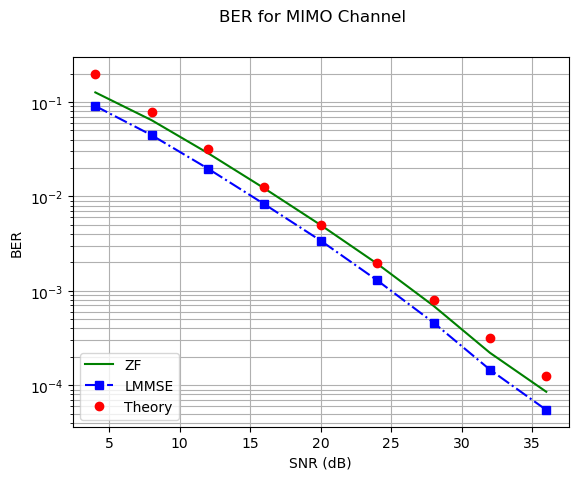

In [5]:
blockLength = 100;
nBlocks = 10000;
r = 2;
t = 2;
EbdB = np.arange(1.0,33.1,4.0);
Eb = 10**(EbdB/10);
No = 1;
Es = 2*Eb;
SNR = Es/No;
SNRdB = 10*np.log10(SNR);
BER_ZF = np.zeros(len(EbdB));
BER_LMMSE = np.zeros(len(EbdB));
BERt = np.zeros(len(EbdB));


for blk in range(nBlocks):
    H = (nr.normal(0.0, 1.0,(r,t)) + 1j*nr.normal(0.0, 1.0,(r,t)))/np.sqrt(2);
    noise = nr.normal(0.0, np.sqrt(No/2), (r,blockLength)) + 1j*nr.normal(0.0, np.sqrt(No/2), (r,blockLength));
    BitsI = nr.randint(2, size=(t, blockLength));
    BitsQ = nr.randint(2, size=(t, blockLength));
    Sym = (2*BitsI-1) +1j*(2*BitsQ-1);

    for K in range(len(SNRdB)):
        TxSym = np.sqrt(Eb[K])*Sym;
        RxSym = np.matmul(H,TxSym) + noise;
         # ZF Receiver
        ZFRx = nl.pinv(H);
        ZFout = np.matmul(ZFRx, RxSym);
        DecBitsI_ZF = (np.real(ZFout)>0);
        DecBitsQ_ZF = (np.imag(ZFout)>0);
        BER_ZF[K] = BER_ZF[K] + np.sum(DecBitsI_ZF != BitsI) + np.sum(DecBitsQ_ZF != BitsQ);

        LMMSERx = np.matmul(nl.inv(MIMO.AHA(H) + No*np.identity(t)/Es[K]),MIMO.H(H));
        LMMSEout = np.matmul(LMMSERx, RxSym);
        DecBitsI_LMMSE = (np.real(LMMSEout)>0);
        DecBitsQ_LMMSE = (np.imag(LMMSEout)>0);

        BER_LMMSE[K] = BER_LMMSE[K] + np.sum(DecBitsI_LMMSE != BitsI) + np.sum(DecBitsQ_LMMSE != BitsQ);


BER_ZF = BER_ZF/blockLength/nBlocks/2/t;
BER_LMMSE = BER_LMMSE/blockLength/nBlocks/2/t;
L=r-t+1;
BERt = comb(2*L-1, L)/2**L/SNR**L;

plt.yscale('log')
plt.plot(SNRdB, BER_ZF,'g-');
plt.plot(SNRdB, BER_LMMSE,'b-.s');
plt.plot(SNRdB, BERt,'ro');
plt.grid(1,which='both')
plt.suptitle('BER for MIMO Channel')
plt.legend(["ZF","LMMSE", "Theory"], loc ="lower left");
plt.xlabel('SNR (dB)')
plt.ylabel('BER')

**Conclusion**: Implemented a 2x2 MIMO system. We observe that the LMMSE receiver performs better than the ZF receiver at low SNR. But as SNR goes on increasing the difference between the two tends to zero.

<h2 style='text-align: center;'>Project 2</h2>

# Plotting MIMO capacity for equal vs. optimal power allocation using the Water filling algorithm

Text(0, 0.5, 'Capacity (b/s/Hz)')

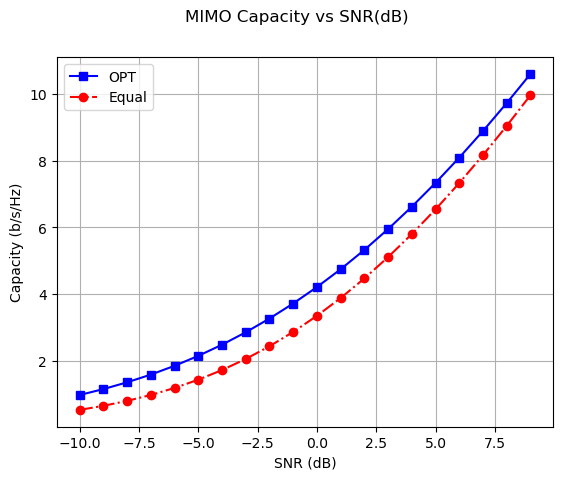

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nr
import MIMO


SNRdB = np.arange(-10,10,1);
SNR = 10**(SNRdB/10);
r = 4;
t = 4;
numBlocks = 10000;
# Initialize capacity arrays
Capacity_OPT = np.zeros(len(SNRdB))
Capacity_EQ = np.zeros(len(SNRdB))


for L in range(numBlocks):
    H = (nr.normal(0.0, 1.0,(r,t))+1j*nr.normal(0.0, 1.0,(r,t)))/np.sqrt(2)
    for kx in range(len(SNRdB)):
       Capacity_OPT[kx] = Capacity_OPT[kx] + MIMO.OPT_CAP_MIMO(H, SNR[kx]);
       Capacity_EQ[kx] += MIMO.EQ_CAP_MIMO(H, SNR[kx]);



Capacity_OPT = Capacity_OPT/numBlocks;
Capacity_EQ = Capacity_EQ/numBlocks;


plt.plot(SNRdB,Capacity_OPT,'b-s');
plt.plot(SNRdB,Capacity_EQ,'r-.o');
plt.grid(1,which='both')
plt.legend(["OPT","Equal"], loc ="upper left");
plt.suptitle('MIMO Capacity vs SNR(dB)')
plt.xlabel('SNR (dB)')
plt.ylabel('Capacity (b/s/Hz)')



**Conclusion**: Implemented a 4x4. We see that the optimal power allocation obtained from the Water Filling Algorithm leads to a higher capacity than equal power allocation at all SNR levels.

<h2 style='text-align: center;'>Project 3</h2>

# Performed simulation for MIMO-OFDM system and analysed the BER performance for varying SNR

Text(0, 0.5, 'BER')

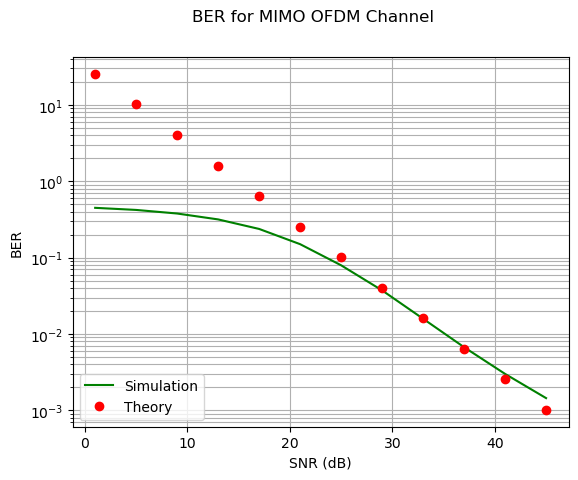

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nr
import numpy.linalg as nl
import numpy.fft as nf
from scipy.special import comb


Nsub = 256;
Ncp = int(Nsub/4);
nBlocks = 100;
L = 2;
r = 2;
t = 2;
EbdB = np.arange(1.0,45.1,4.0);
Eb = 10**(EbdB/10);
No = 1;
SNR = 2*Eb/No;
SNRdB = 10*np.log10(Eb/No);
BER = np.zeros(len(EbdB));
BERt = np.zeros(len(EbdB));
RxSamCP = np.zeros((r,L+Nsub+Ncp-1))+1j*np.zeros((r,L+Nsub+Ncp-1));
RxSamples = np.zeros((r,Nsub))+1j*np.zeros((r,Nsub));
RxSym = np.zeros((r,Nsub))+1j*np.zeros((r,Nsub));
Hfft = np.zeros((r,t,Nsub))+1j*np.zeros((r,t,Nsub));
TxSamples = np.zeros((t,Nsub))+1j*np.zeros((t,Nsub));
TxSamCP = np.zeros((t,Nsub+Ncp))+1j*np.zeros((t,Nsub+Ncp));

for blk in range(nBlocks):    
    noise = nr.normal(0.0, np.sqrt(No/2),(r,L+Nsub+Ncp-1))+1j*nr.normal(0.0, np.sqrt(No/2),(r,L+Nsub+Ncp-1));
    H = (nr.normal(0.0, 1.0,(r,t,L))+1j*nr.normal(0.0, 1.0,(r,t,L)))/np.sqrt(2);
    BitsI = nr.randint(2,size=(t,Nsub));
    BitsQ = nr.randint(2,size=(t,Nsub));
    Sym = (2*BitsI-1)+1j*(2*BitsQ-1);

    for K in range(len(SNRdB)):
        LoadedSym = np.sqrt(Eb[K])*Sym;
        for tx in range(t):
            TxSamples[tx,:] = nf.ifft(LoadedSym[tx,:]);
            TxSamCP[tx,:] = np.concatenate((TxSamples[tx,Nsub-Ncp:Nsub],TxSamples[tx,:])); 

        RxSamCP = np.zeros((r,L+Nsub+Ncp-1))+1j*np.zeros((r,L+Nsub+Ncp-1));
        for rx in range(r):
            for tx in range(t):
                RxSamCP[rx,:]+= np.convolve(H[rx,tx,:],TxSamCP[tx,:])
                Hfft[rx,tx,:] = nf.fft(np.concatenate((H[rx,tx,:],np.zeros(Nsub-L))));
            RxSamCP[rx,:]+= noise[rx,:];
            RxSamples[rx,:] = RxSamCP[rx,Ncp:Ncp+Nsub];
            RxSym[rx,:] = nf.fft(RxSamples[rx,:]);
        for nx in range(Nsub):
            ZFout = np.matmul(nl.pinv(Hfft[:,:,nx]),RxSym[:,nx]);
            DecBitsI = (np.real(ZFout)>0);
            DecBitsQ = (np.imag(ZFout)>0);
            BER[K] = BER[K]+np.sum(DecBitsI!=BitsI[:,nx]) + np.sum(DecBitsQ!=BitsQ[:,nx]);
                
BER = BER/nBlocks/Nsub/t/2;
SNReff = SNR*L/Nsub;
L=r-t+1;    
BERt = comb(2*L-1, L)/2**L/SNReff**L; # BER for ZF from formula

plt.yscale('log')
plt.plot(SNRdB, BER,'g-');
plt.plot(SNRdB, BERt,'ro');
plt.grid(1,which='both')
plt.suptitle('BER for MIMO OFDM Channel')
plt.legend(["Simulation", "Theory"], loc ="lower left");
plt.xlabel('SNR (dB)')
plt.ylabel('BER') 

<h2 style='text-align: center;'>Project 4</h2>

# Plotting the capacity of Massive MIMO channel with and without power scaling

With Power scaling

Text(0.5, 0, 'Number of antennas M')

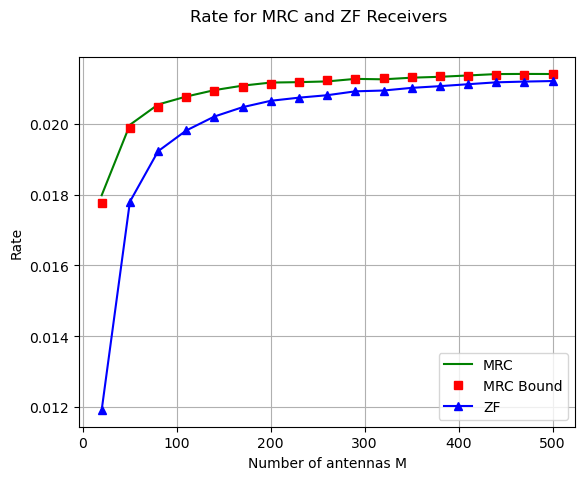

In [18]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import matplotlib.pyplot as plt
import MIMO

ITER = 3000;
K = 10; # number of users
Mv = np.arange(20,520,30); # number of BS antennas
Eu_dB = 10;  Eu = 10**(Eu_dB/10);
rate_MRC = np.zeros(len(Mv)) ;
bound_MRC = np.zeros(len(Mv));
rate_ZF = np.zeros(len(Mv));

beta = MIMO.Dmatrix(K); # Models the large scale fading of the channel gives a log normal RV
sqrtD = np.diag(np.sqrt(beta));

for it in range(ITER):
  # print(it)
  for mx in range(len(Mv)):
    M = Mv[mx]
    #pu = Eu # no power scaling
    pu = Eu/M # power scaling
    H = (nr.normal(0, 1,(M,K)) + 1j*nr.normal(0, 1, (M,K)))/np.sqrt(2)
    G = np.matmul(H,sqrtD)  # Contains both H info and Beta info. MxK matrix
    g0 = G[:,0]; # column user 0
    MRCbf = g0/nl.norm(g0)   # beamforming vector
    nr_MRC = pu*nl.norm(g0)**2   # numerator of the SINR
    nr_bound_MRC = pu*M*beta[0]
    dr_bound_MRC = 1
    mu_int = np.matmul(MIMO.H(MRCbf), G[:,1:])  # multi user interference of all the other channels except 0
    dr_MRC = 1 + pu * nl.norm(mu_int)**2  # noise power and the interference power
    dr_bound_MRC = dr_bound_MRC + pu*np.sum(beta[1:])
    rate_MRC[mx] = rate_MRC[mx] + np.log2(1 + nr_MRC/dr_MRC)  # calculating the capacity bits/sec/Hz
    bound_MRC[mx] = bound_MRC[mx] + np.log2(1 + nr_bound_MRC/dr_bound_MRC)

    GG = np.matmul(MIMO.H(G),G)
    nr_ZF = pu
    invGG = nl.inv(GG)
    dr_ZF = np.real(invGG[0,0])
    rate_ZF[mx] = rate_ZF[mx] + np.log2(1+nr_ZF/dr_ZF)



rate_MRC = rate_MRC/ITER;
bound_MRC = bound_MRC/ITER;
rate_ZF = rate_ZF/ITER;


plt.plot(Mv, rate_MRC,'g-');
plt.plot(Mv, bound_MRC,'rs');
plt.plot(Mv, rate_ZF,'b^-');
plt.grid(1,which='both')
plt.legend(["MRC", "MRC Bound", "ZF"], loc ="lower right");
plt.suptitle('Rate for MRC and ZF Receivers')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')


**Conclusion**: Observing the plot above we see that even though the power of a user is being scaled according to the number of antennas we maintain a constant rate which is one of the major advantage of a Massive MIMO.

Without Power scaling

Text(0.5, 0, 'Number of antennas M')

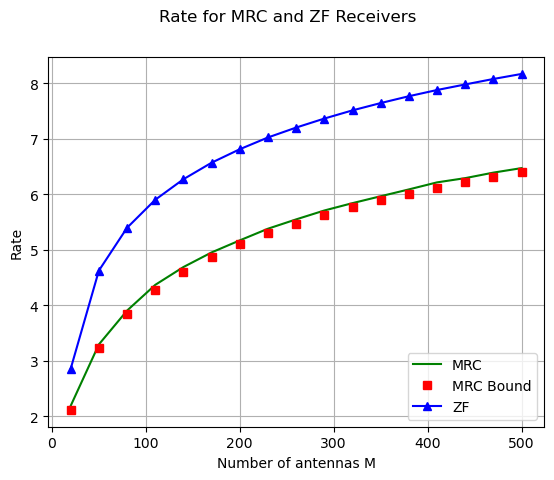

In [19]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import matplotlib.pyplot as plt
import MIMO

ITER = 3000;
K = 10; # number of users
Mv = np.arange(20,520,30); # number of BS antennas
Eu_dB = 10;  Eu = 10**(Eu_dB/10);
rate_MRC = np.zeros(len(Mv)) ;
bound_MRC = np.zeros(len(Mv));
rate_ZF = np.zeros(len(Mv));

beta = MIMO.Dmatrix(K); # Models the large scale fading of the channel gives a log normal RV
sqrtD = np.diag(np.sqrt(beta));

for it in range(ITER):
  # print(it)
  for mx in range(len(Mv)):
    M = Mv[mx]
    pu = Eu # no power scaling
    #pu = Eu/M # power scaling
    H = (nr.normal(0, 1,(M,K)) + 1j*nr.normal(0, 1, (M,K)))/np.sqrt(2)
    G = np.matmul(H,sqrtD)  # Contains both H info and Beta info. MxK matrix
    g0 = G[:,0]; # column user 0
    MRCbf = g0/nl.norm(g0)   # beamforming vector
    nr_MRC = pu*nl.norm(g0)**2   # numerator of the SINR
    nr_bound_MRC = pu*M*beta[0]
    dr_bound_MRC = 1
    mu_int = np.matmul(MIMO.H(MRCbf), G[:,1:])  # multi user interference of all the other channels except 0
    dr_MRC = 1 + pu * nl.norm(mu_int)**2  # noise power and the interference power
    dr_bound_MRC = dr_bound_MRC + pu*np.sum(beta[1:])
    rate_MRC[mx] = rate_MRC[mx] + np.log2(1 + nr_MRC/dr_MRC)  # calculating the capacity bits/sec/Hz
    bound_MRC[mx] = bound_MRC[mx] + np.log2(1 + nr_bound_MRC/dr_bound_MRC)

    GG = np.matmul(MIMO.H(G),G)
    nr_ZF = pu
    invGG = nl.inv(GG)
    dr_ZF = np.real(invGG[0,0])
    rate_ZF[mx] = rate_ZF[mx] + np.log2(1+nr_ZF/dr_ZF)



rate_MRC = rate_MRC/ITER;
bound_MRC = bound_MRC/ITER;
rate_ZF = rate_ZF/ITER;


plt.plot(Mv, rate_MRC,'g-');
plt.plot(Mv, bound_MRC,'rs');
plt.plot(Mv, rate_ZF,'b^-');
plt.grid(1,which='both')
plt.legend(["MRC", "MRC Bound", "ZF"], loc ="lower right");
plt.suptitle('Rate for MRC and ZF Receivers')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')


**Conclusion**: Observing the plot above we see that without scaling the power of a user the rate goes on increasing as we keep on increasing number of antenna M.